In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
# change plot style
plt.style.use('ggplot')
# increase max number of columns displayed
pd.set_option('display.max_columns', 200)


In [3]:
# read data into dataframe
df = pd.read_excel('Zephyr_Export_3.xls', sheet_name=1)

WARNING *** file size (334746) not 512 + multiple of sector size (512)


In [4]:
df.head()

Unnamed: 0   Deal Number Deal value\nth EUR Deal status  \
0         1.0  1.909545e+09    134,715,295.00*   Withdrawn   
1         NaN           NaN                NaN         NaN   
2         2.0  1.909650e+09    114,532,984.98*   Withdrawn   
3         3.0  1.909095e+09     85,746,684.31*   Withdrawn   
4         4.0  5.358940e+05     64,590,599.98*   Withdrawn   

  Target stock price prior to announcement\nEUR  \
0                                          n.a.   
1                                          n.a.   
2                                          n.a.   
3                                          n.a.   
4                                     72.874837   

  Acquiror operating revenue/turnover\nth EUR\nLast avail. yr  \
0                                    23001570.174142            
1                                                NaN            
2                                               n.a.            
3                                       71771126.112            
4                                       62672578.716            

  Target operating revenue/turnover\nth EUR\nLast avail. yr  \
0                                          2281000.0          
1                                            2976000          
2                                     45611254.28158          
3                                               n.a.          
4                                        56061259.38          

                                 Target major sector  \
0  Chemicals, rubber, plastics, non-metallic prod...   
1  Chemicals, rubber, plastics, non-metallic prod...   
2         Machinery, equipment, furniture, recycling   
3  Chemicals, rubber, plastics, non-metallic prod...   
4                            Metals & metal products   

                               Acquiror major sector  \
0                           Food, beverages, tobacco   
1                                                NaN   
2         Machinery, equipment, furniture, recycling   
3  Chemicals, rubber, plastics, non-metallic prod...   
4                            Metals & metal products   

  Acquiror net profit\nth EUR\nLast avail. yr  \
0                               893847.976969   
1                                         NaN   
2                                        n.a.   
3                                 19406669.52   
4                                        n.a.   

  Target net profit\nth EUR\nLast avail. yr  
0                                  454000.0  
1                                  18946000  
2                           13349031.343586  
3                                      n.a.  
4                              18624398.856

In [5]:
# transforming of n.a. (string) values to nan values
df = df.replace('n.a.', np.nan).copy()

In [6]:
# drop first two useless features
df = df.drop(df.columns[0:2], axis=1).copy()

In [7]:
# check number of nan values
df.isna().sum()

Deal value\nth EUR                                              591
Deal status                                                     281
Target stock price prior to announcement\nEUR                   807
Acquiror operating revenue/turnover\nth EUR\nLast avail. yr     846
Target operating revenue/turnover\nth EUR\nLast avail. yr       446
Target major sector                                             284
Acquiror major sector                                            98
Acquiror net profit\nth EUR\nLast avail. yr                    1168
Target net profit\nth EUR\nLast avail. yr                       860
dtype: int64

In [8]:
# check unique values
df.nunique()

Deal value\nth EUR                                             930
Deal status                                                      3
Target stock price prior to announcement\nEUR                  680
Acquiror operating revenue/turnover\nth EUR\nLast avail. yr    540
Target operating revenue/turnover\nth EUR\nLast avail. yr      825
Target major sector                                             19
Acquiror major sector                                           19
Acquiror net profit\nth EUR\nLast avail. yr                    324
Target net profit\nth EUR\nLast avail. yr                      581
dtype: int64

In [9]:
# check data types
df.dtypes

Deal value\nth EUR                                              object
Deal status                                                     object
Target stock price prior to announcement\nEUR                  float64
Acquiror operating revenue/turnover\nth EUR\nLast avail. yr    float64
Target operating revenue/turnover\nth EUR\nLast avail. yr      float64
Target major sector                                             object
Acquiror major sector                                           object
Acquiror net profit\nth EUR\nLast avail. yr                    float64
Target net profit\nth EUR\nLast avail. yr                      float64
dtype: object

# Feature engineering

In [10]:
# drop the column with too many nan values
df = df.drop(columns=['Acquiror net profit\nth EUR\nLast avail. yr']).copy()

# engineer strings in deal value column
df['Deal value\nth EUR'] = df['Deal value\nth EUR'].apply(lambda x: float(str(x)
                                                               .replace('*', '')
                                                               .replace(',', '')
                                                               .replace('.', '')
                                                               .strip()
                                                              ))
# drop cat features with nan values
df = df.dropna(subset=['Deal status',
                       'Acquiror major sector', 
                       'Target major sector'], how='any')


# one-hot encoding of features with more than two categories
df = pd.concat([df['Deal status'],
                     pd.get_dummies(df.drop('Deal status', axis=1),
                                    drop_first=True)], axis=1).copy()
# change variable name seperators
df.columns = (column.replace(" ", "_").replace("(", "_")
              .replace("&", "_").replace("-", "_").replace("\\", "_")
              for column in df.columns)


In [ ]:
# check new dataframe
df.head()

# Exploratory Data Analysis

In [ ]:
df.describe()

Completed            727
Withdrawn            270
Completed Assumed    149
Name: Deal_status, dtype: int64


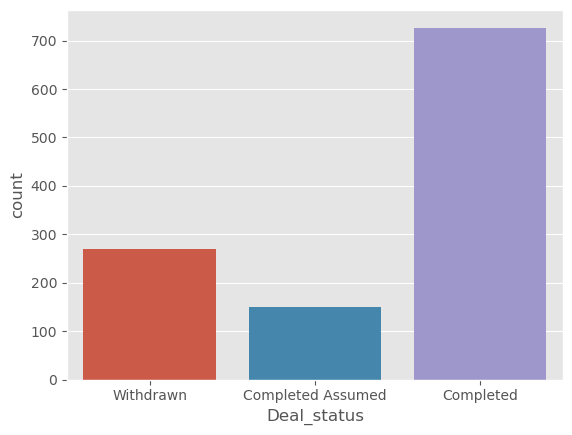

In [11]:
# check target variable
print(df['Deal_status'].value_counts())
sns.countplot(x='Deal_status', data=df,)
plt.show()

In [12]:
# drop rows for completed assumed
df = df[df['Deal_status'] != 'Completed Assumed'].copy()
# change target variable to binary
df['Deal_status'] = df['Deal_status'].map({'Completed':1, 'Withdrawn':0})

dropped because we 'completed assumed' is a small sample size and we don't know whether those are actually completed, potentially creating bias if merged.

1    727
0    270
Name: Deal_status, dtype: int64


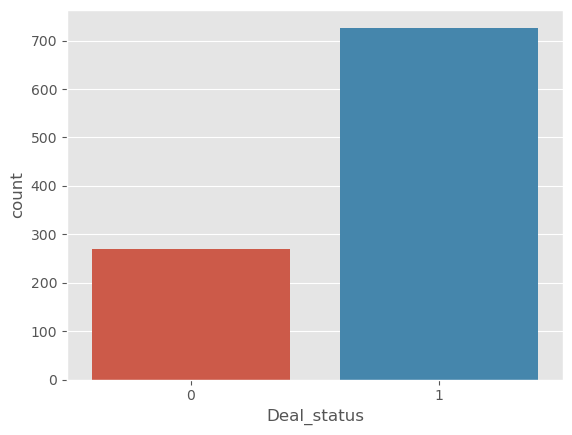

In [13]:
# new target variable distribution after dropping 
print(df['Deal_status'].value_counts())
sns.countplot(x='Deal_status', data=df)
plt.show()

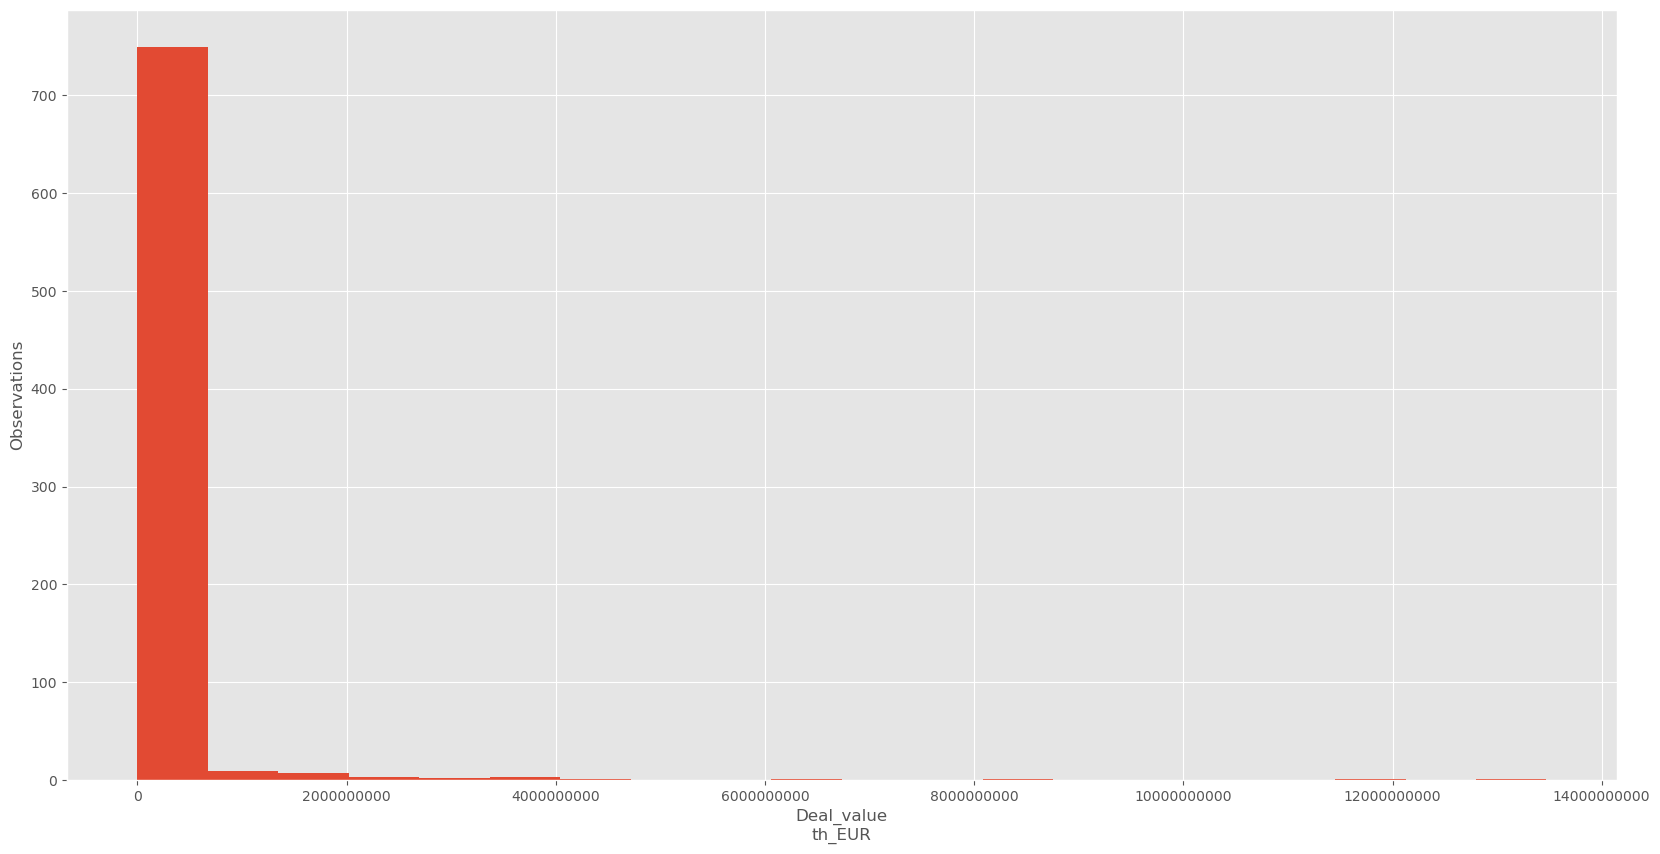

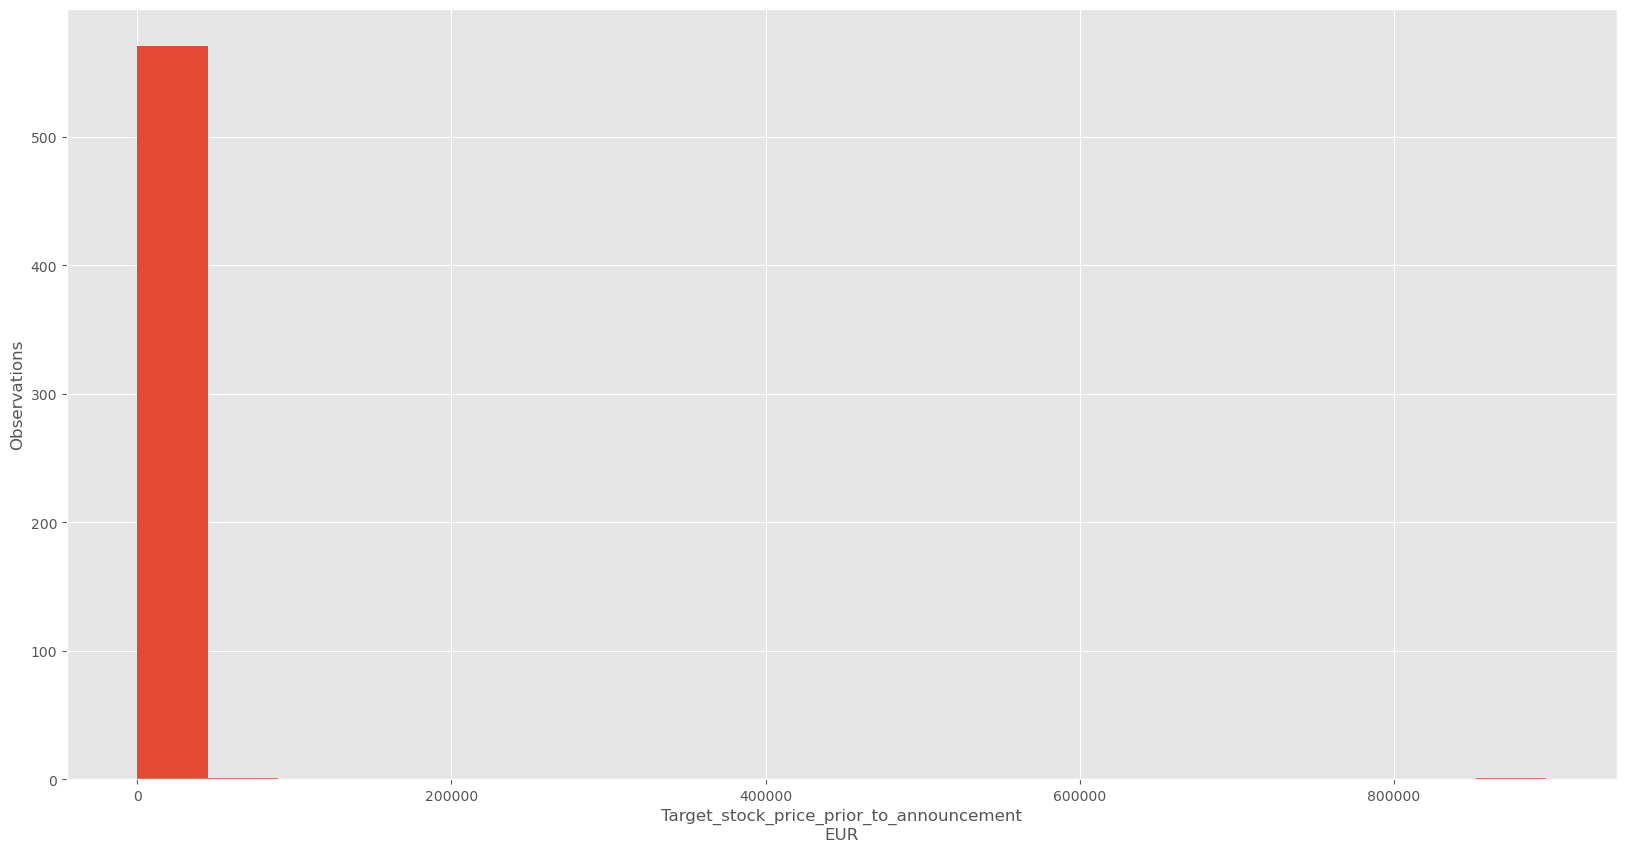

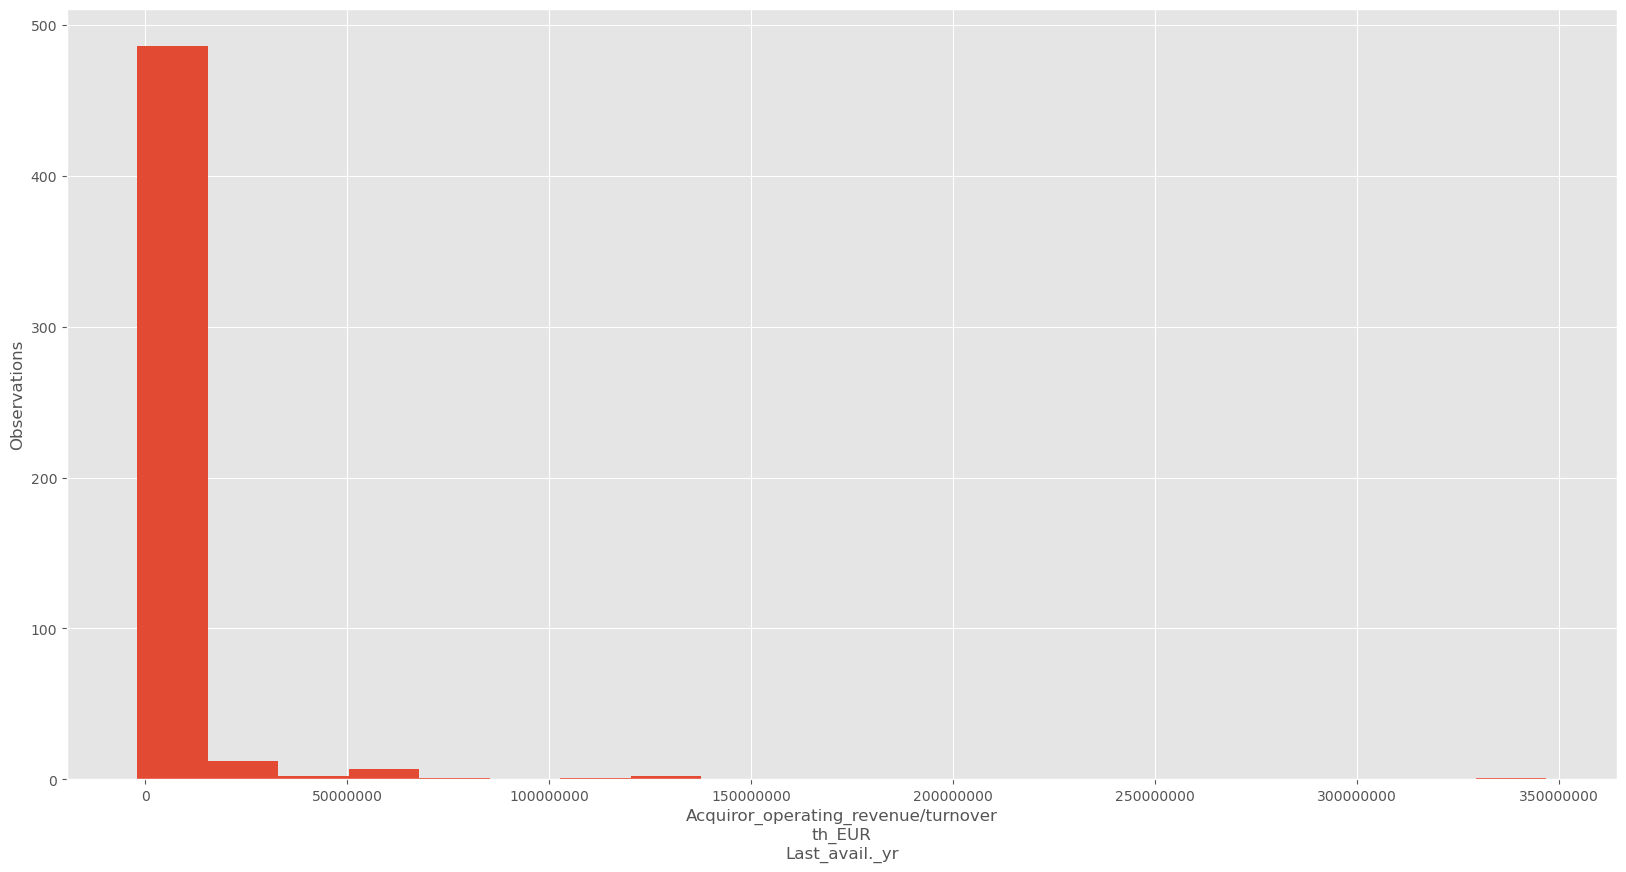

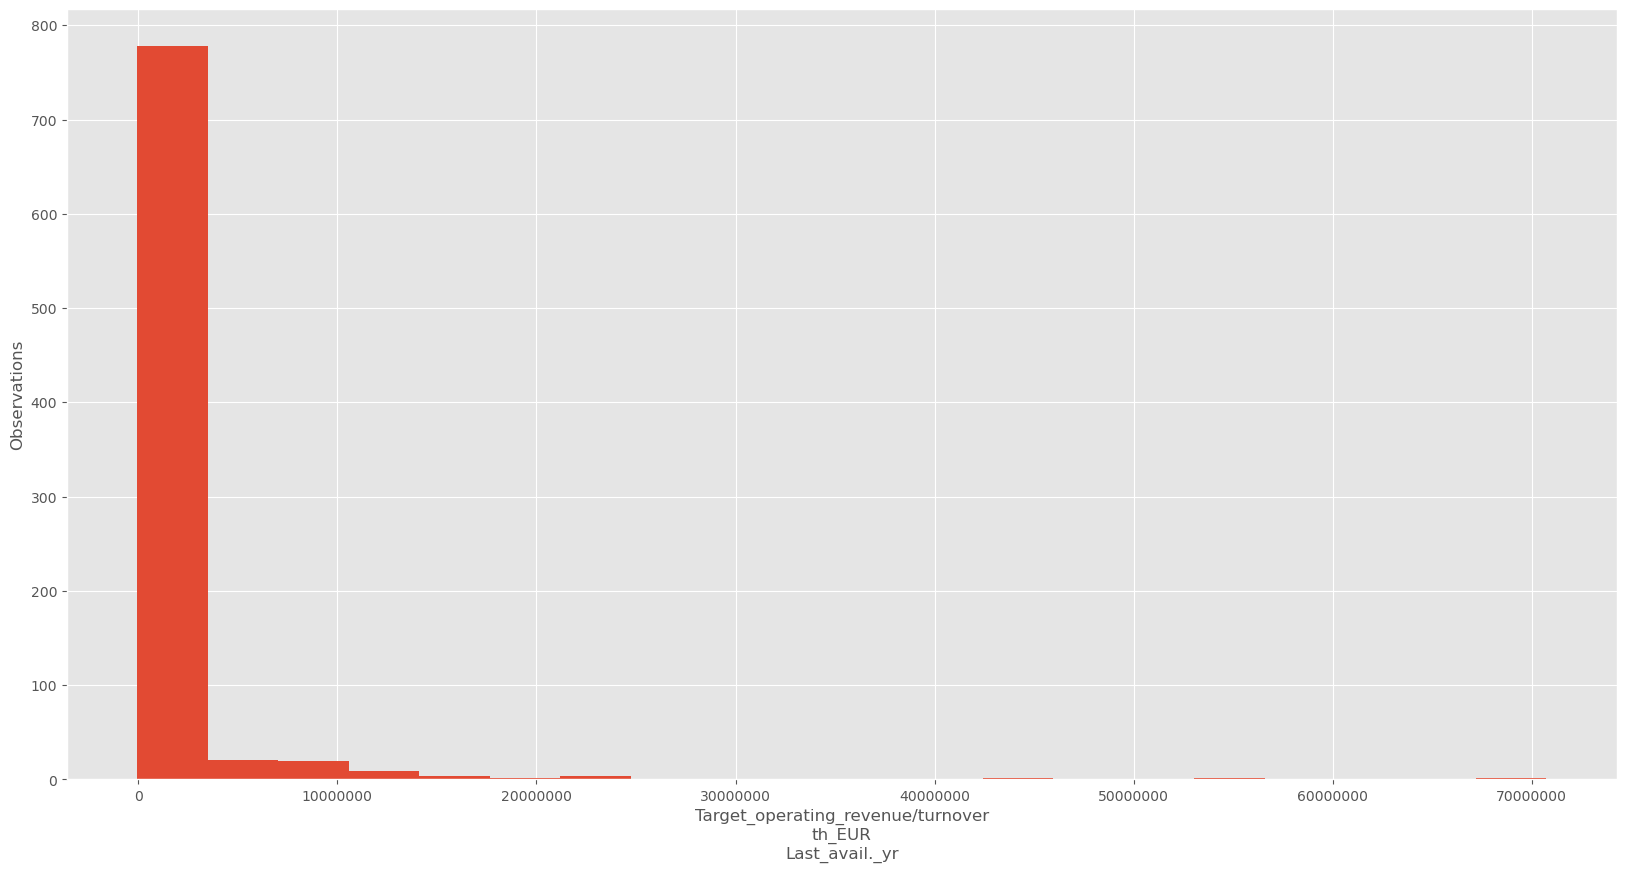

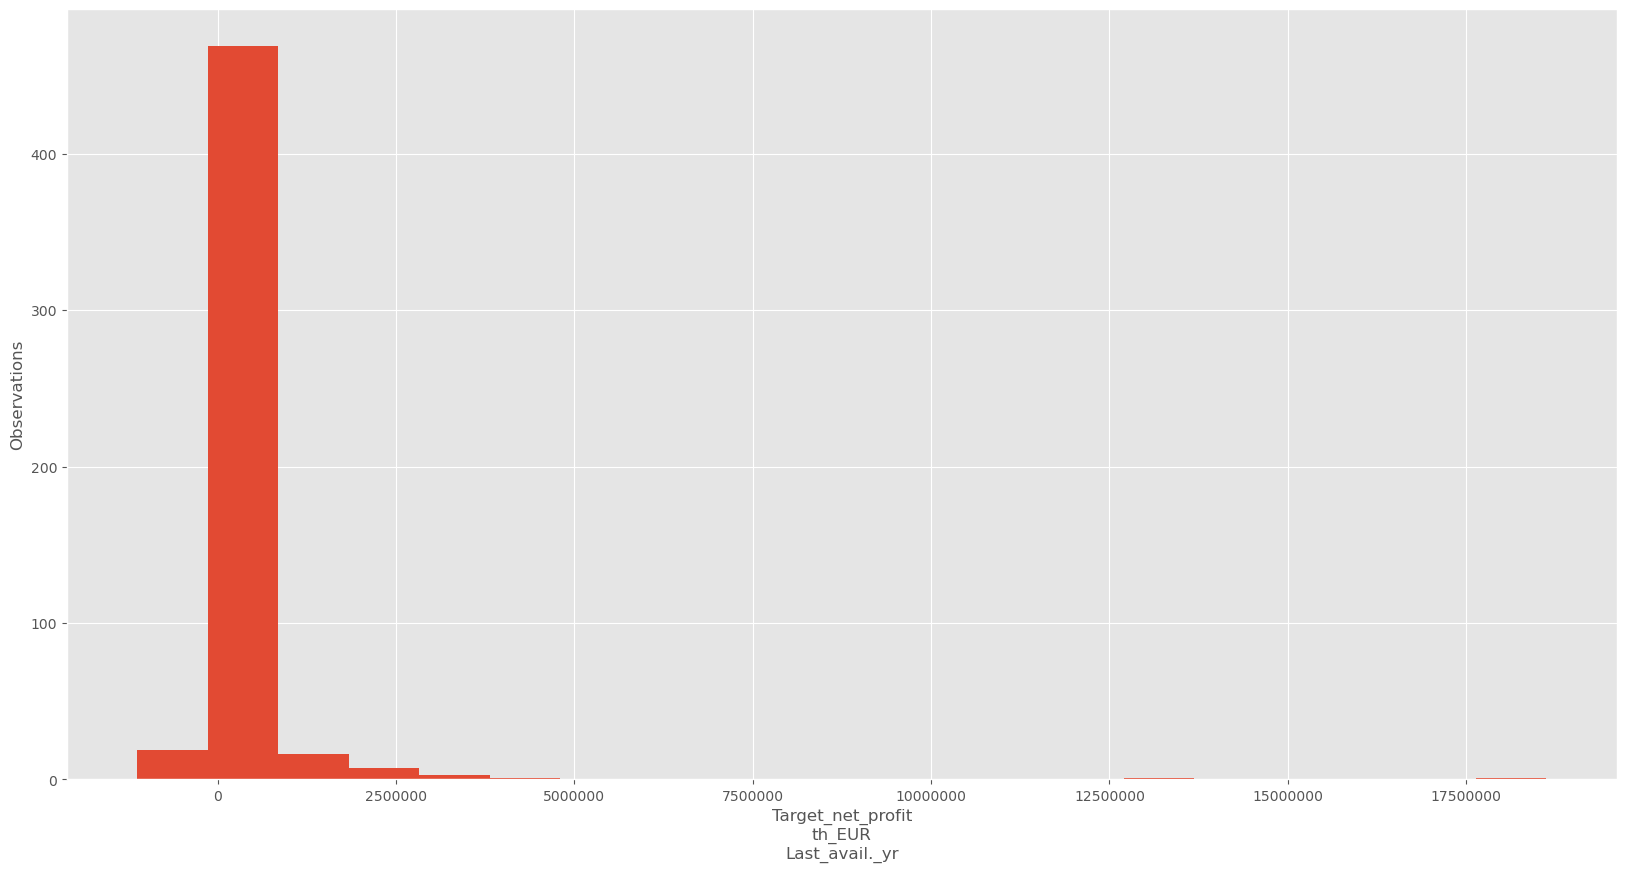

In [14]:
# select all numerical variables
num_vals = df.select_dtypes(include='float64').columns

# plot histogram for all numerical values
for n in num_vals:
    df[n].hist(bins=20, figsize=(20, 10))
    plt.xlabel(n)
    plt.ylabel('Observations')
    plt.ticklabel_format(useOffset=False, style='plain')
    # show plot
    plt.show()

Pretty much all these distributions are right skewed. This results in the mean being greater than the median, and the mode typically being less than the median. There is a natural lower limit to the values in the distribution, causing a long tail to the right

In [15]:
# impute median for numerical variables to get rid of nan values
num_vals = df.select_dtypes(include='float64').columns

for n in num_vals:
    m = df[n].median()
    df[n] = df[n].fillna(m)  

In [16]:
df[num_vals].isna().sum()

Deal_value\nth_EUR                                             0
Target_stock_price_prior_to_announcement\nEUR                  0
Acquiror_operating_revenue/turnover\nth_EUR\nLast_avail._yr    0
Target_operating_revenue/turnover\nth_EUR\nLast_avail._yr      0
Target_net_profit\nth_EUR\nLast_avail._yr                      0
dtype: int64

In [33]:
"""plot all numerical variables against each other
with blue points highlighting that deal_status is withdrawn 
and red points highlighting that deal_status is completed"""

# increase description size
sns.set(font_scale=6)
# increase legend size
sns.set_style({'legend.markerscale': 400})
# plot all numerical variables
g = sns.pairplot(df, vars=num_vals, hue='Deal_status', 
                 height=20, aspect=1.5,
                 plot_kws={'s': 1000, 'alpha': 1})
g.fig.autofmt_xdate(rotation=45)

plt.show()

In [17]:
# correlations between target variable and independent variables
df_corr = df.corr()
target_corr = df_corr.loc['Deal_status', :]
print(target_corr)

Deal_status                                                                 1.000000
Deal_value\nth_EUR                                                         -0.220654
Target_stock_price_prior_to_announcement\nEUR                               0.020398
Acquiror_operating_revenue/turnover\nth_EUR\nLast_avail._yr                -0.134447
Target_operating_revenue/turnover\nth_EUR\nLast_avail._yr                  -0.201667
Target_net_profit\nth_EUR\nLast_avail._yr                                  -0.124290
Target_major_sector_Chemicals,_rubber,_plastics,_non_metallic_products     -0.007928
Target_major_sector_Construction                                            0.012180
Target_major_sector_Education,_Health                                      -0.155676
Target_major_sector_Food,_beverages,_tobacco                                0.007961
Target_major_sector_Gas,_Water,_Electricity                                 0.034140
Target_major_sector_Hotels___restaurants                         

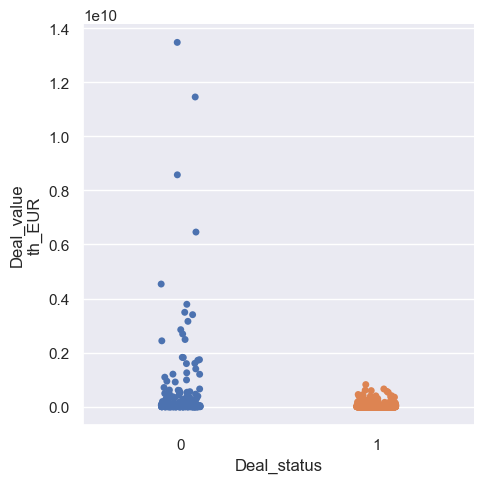

In [38]:
sns.set(font_scale=1)
sns.catplot(data=df, x="Deal_status", y="Deal_value\nth_EUR", order=[0, 1])

no strong (pearson) correlation 

# Model

In [18]:
# feature scaling
from sklearn.preprocessing import MinMaxScaler

# Imports GLM 
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Import Machine learning algorithms
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.preprocessing import StandardScaler # Import Feature Importance StandardScaler

# Import metric for performance evaluation
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

# undersampling for class imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn import tree


In [19]:
# split for GLM exploration
X = df.drop('Deal_status', axis=1)
y = df['Deal_status']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                   y, test_size=0.3, random_state=42, stratify=y)
        

In [20]:
import plotly.express as px 

# visualize correlation between features
corr = X_train.corr()
fig = px.imshow(corr, width=1000, height=1000)
fig.show()

# potentially drop highly correleated features
cor_matrix = X_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

print("Highly correlated feature(s) dropped: ", to_drop)

Highly correlated feature(s) dropped:  ['Acquiror_major_sector_Education,_Health']


In [21]:
# feature scaling for logistic regression - MinMax Scaler (better for data sets that include outliers and/or skewed data)
sc = MinMaxScaler()
to_scale = [col for col in X_train.columns if X_train[col].nunique() > 2]

for col in to_scale:
    X_train[col] = sc.fit_transform(X_train[[col]])
    X_test[col] = sc.transform(X_test[[col]])  

In [22]:
# dealing with class imbalance
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_train, y_train = rus.fit_resample(X_train, y_train)
print('Toal numer of observation after balancing: ', len(X_train))

Toal numer of observation after balancing:  378


In [26]:
from sklearn.metrics import PrecisionRecallDisplay


def do_classify(clf, parameters, Xtr,ytr,Xdev,ydev, score_func=None, n_folds=5, n_jobs=2,model_name='model',label=1,prob_dec=1):

    if parameters:
        clf = cv_optimize(clf, parameters, Xtr, ytr, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtr, ytr)
    training_accuracy = clf.score(Xtr, ytr)
    test_accuracy = clf.score(Xdev, ydev)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (100*training_accuracy)+'%')
    print("Accuracy on test data:     %0.2f" % (100*test_accuracy)+'%')
    print("confusion_matrix on test data")
    ypred =  clf.predict(Xdev)
    print(confusion_matrix(ydev,ypred))
    print("classification report on test data")
    print(classification_report(ydev,ypred))
    print("########################################################")
    #  multi_auc_roc(clf,Xdev,ydev,prob=1)
    auc_tr = find_auc_score(clf,Xtr,ytr,color='g',name=model_name+'_tr',label=label,prob=prob_dec) 
    auc_dev = find_auc_score(clf,Xdev,ydev,color='orange',name=model_name+'_tst',label=label,prob=prob_dec)
    # precision recall curve
    recall_precision(clf,Xdev,ydev)
    return clf,auc_tr,auc_dev

def cv_optimize(clf, parameters, X, y, n_jobs=2, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    #print(gs.grid_scores_)
    best = gs.best_estimator_
    return best

def find_auc_score(clf,Xin,yin,color='b',name='LogReg',label=1,prob=1) :
    '''Function to plot Receiver characteristics and find AUC'''
    if prob == 1:
        yscore = clf.predict_proba(Xin)
    else :
        yscore = clf.decision_function(Xin)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yin, yscore[:,label],pos_label=label)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    fig = plt.plot(false_positive_rate, true_positive_rate, color ,label='AUC '+name+' = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')   
    return roc_auc

# alternative simple roc plot
def plot_roc(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test) 
    plt.title(name)
    plt.show()
    def accuracy_report(y_pred):
        print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
    accuracy_report(y_pred)
    
    
def recall_precision(clf,Xin,yin):
    yscore = clf.predict_proba(Xin)
    precision, recall, threshold = precision_recall_curve(y_test, 
                                                      yscore[:,1])
    ap = average_precision_score(y_test, yscore[:,1])
    prd = PrecisionRecallDisplay(precision, recall, average_precision=ap)
    prd.plot()
    return

In [27]:
### Hypertuning Parameters

param1 = {'C' : [0.1,1, 10, 100],
                  'penalty' : ['l1', 'l2'],
                  #'class_weight' : [{0:1,1:5}, {0:1,1:10}, {0:1,1:25}, {0: 1, 1: 0.5}, {0: 1, 1: 0.75}],
                  'random_state' : [0, 42, 100, 200],
                  #'solver' : ['newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
    
}

param2 = {#'class_weight': [{0: 1, 1: 0.5}, {0: 1, 1: 2}, {0: 1, 1: 0.75}, {0:1,1:10}, {0:1,1:25}],
                            'max_depth': [1, 2], #complecxity of model .. more complex can have lower generalisation powere.. will overfit
                            'min_samples_leaf': [1, 2, 3, 5],
                            'criterion': ['gini', 'entropy'],
                            'min_samples_split': [2, 3, 5],
                            'random_state' : [0, 42, 100, 200],
                            'n_estimators': [10, 40, 70] #in ensemble - how many DT
}

param3 = {#'class_weight': [{0: 1, 1: 0.5}, {0: 1, 1: 2}, {0: 1, 1: 0.75}, {0:1,1:10}, {0:1,1:25}],
                            'max_depth': [1,2,3,5], #complecxity of model .. more complex can have lower generalisation powere.. will overfit
                            #'min_samples_split': [2, 5],
                            'criterion' : ['gini', 'entropy'],
                            'random_state' : [0, 42, 100, 200],
}

param4 = {#'class_weight': [{0: 1, 1: 0.5}, {0: 1, 1: 2}, {0: 1, 1: 0.75}, {0:1,1:10}, {0:1,1:25}],
                            'C': [0.1,1, 10, 100], 
                            'gamma': [1,0.1,0.01,0.001],
                            'kernel': ['rbf', 'poly', 'sigmoid']
}

BEST {'C': 100, 'penalty': 'l1', 'random_state': 0} 0.6703675975144119
############# based on standard predict ################
Accuracy on training data: 68.78%
Accuracy on test data:     66.67%
confusion_matrix on test data
[[ 42  39]
 [ 61 158]]
classification report on test data
              precision    recall  f1-score   support

           0       0.41      0.52      0.46        81
           1       0.80      0.72      0.76       219

    accuracy                           0.67       300
   macro avg       0.60      0.62      0.61       300
weighted avg       0.70      0.67      0.68       300

########################################################


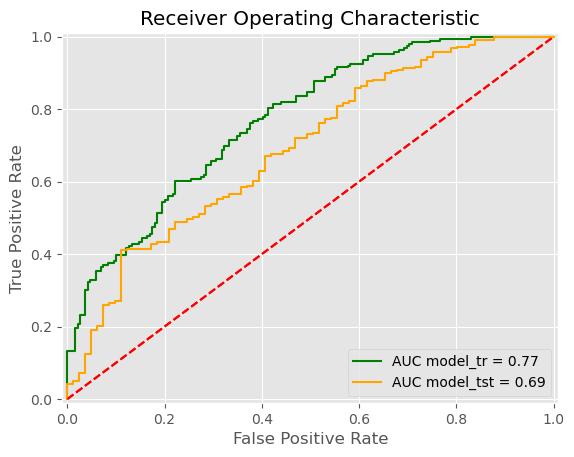

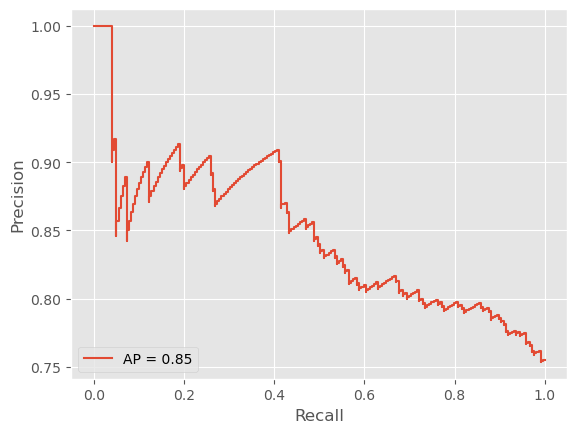

In [28]:
# Logistic Regression Tuning
lg, auc1, auc1 = do_classify(LogisticRegression(verbose=0, solver='liblinear'), param1, X_train,y_train,X_test,y_test, score_func='roc_auc', 
                                 n_folds=5, n_jobs=2,model_name='model',label=1,prob_dec=1)

BEST {'C': 100, 'gamma': 1, 'kernel': 'poly'} 0.6618739237852811
############# based on standard predict ################
Accuracy on training data: 75.13%
Accuracy on test data:     66.67%
confusion_matrix on test data
[[ 43  38]
 [ 62 157]]
classification report on test data
              precision    recall  f1-score   support

           0       0.41      0.53      0.46        81
           1       0.81      0.72      0.76       219

    accuracy                           0.67       300
   macro avg       0.61      0.62      0.61       300
weighted avg       0.70      0.67      0.68       300

########################################################


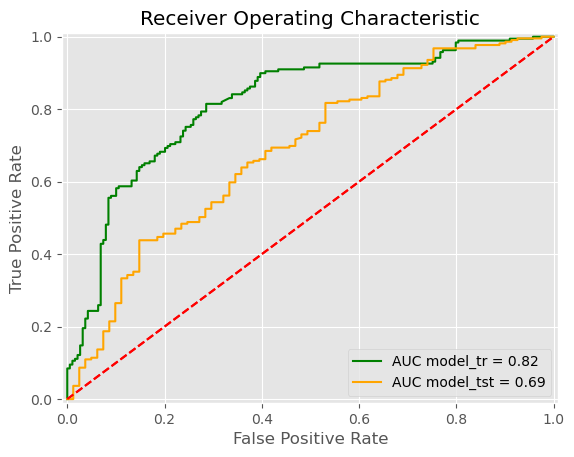

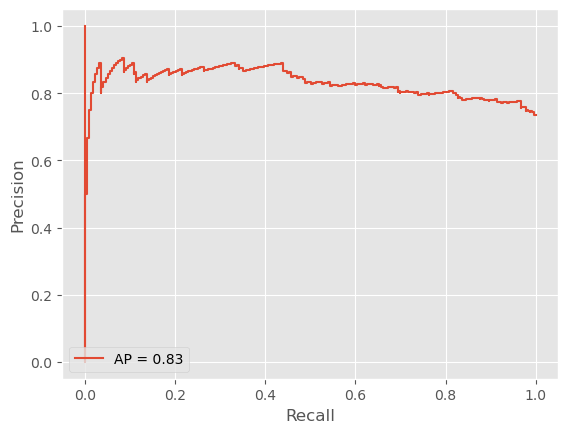

In [29]:
# SVM Tuning
sv, auc4, auc4 = do_classify(svm.SVC(probability=True), param4, X_train,y_train,X_test,y_test, score_func='roc_auc', 
                                 n_folds=5, n_jobs=2,model_name='model',label=1,prob_dec=1)

BEST {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10, 'random_state': 200} 0.7482724414164856
############# based on standard predict ################
Accuracy on training data: 69.84%
Accuracy on test data:     68.67%
confusion_matrix on test data
[[ 51  30]
 [ 64 155]]
classification report on test data
              precision    recall  f1-score   support

           0       0.44      0.63      0.52        81
           1       0.84      0.71      0.77       219

    accuracy                           0.69       300
   macro avg       0.64      0.67      0.64       300
weighted avg       0.73      0.69      0.70       300

########################################################


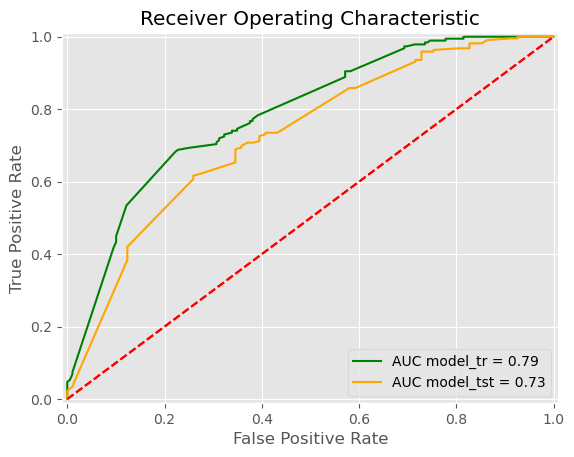

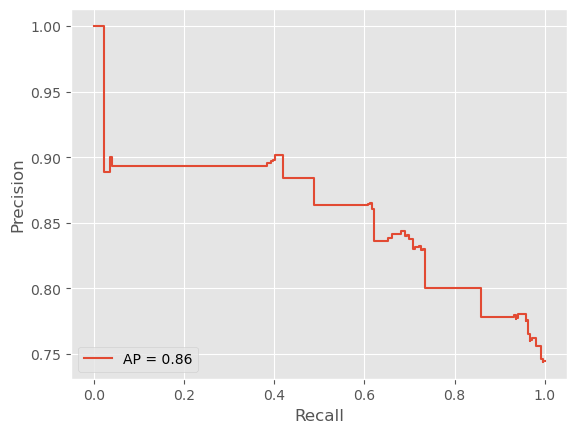

In [30]:
# Random Forest Tunning
rf, auc2, auc2 = do_classify(RandomForestClassifier(verbose=0), param2, X_train,y_train,X_test, y_test, score_func='roc_auc', 
                                 n_folds=5, n_jobs=2, model_name='model', label=1,prob_dec=1)

BEST {'criterion': 'entropy', 'max_depth': 3, 'random_state': 0} 0.7342142696713334
############# based on standard predict ################
Accuracy on training data: 69.84%
Accuracy on test data:     68.00%
confusion_matrix on test data
[[ 50  31]
 [ 65 154]]
classification report on test data
              precision    recall  f1-score   support

           0       0.43      0.62      0.51        81
           1       0.83      0.70      0.76       219

    accuracy                           0.68       300
   macro avg       0.63      0.66      0.64       300
weighted avg       0.73      0.68      0.69       300

########################################################


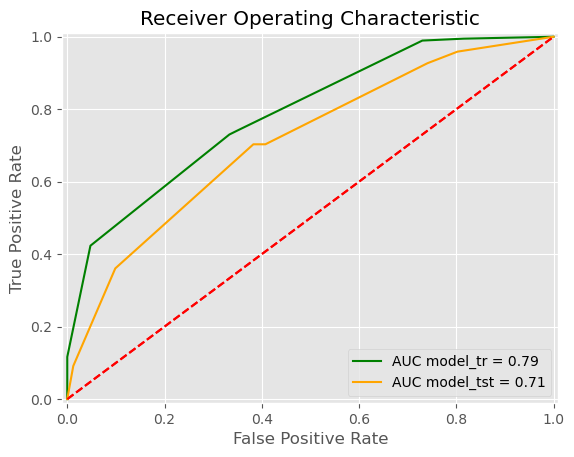

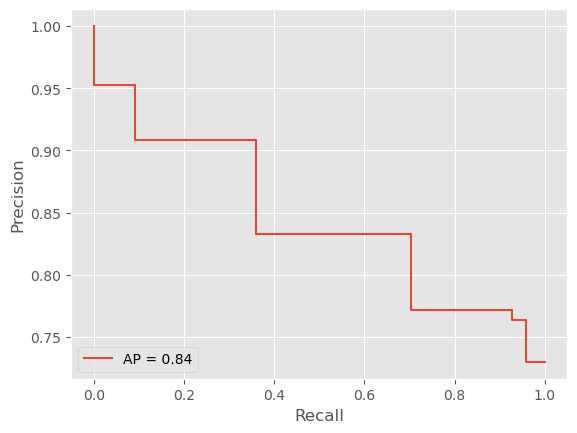

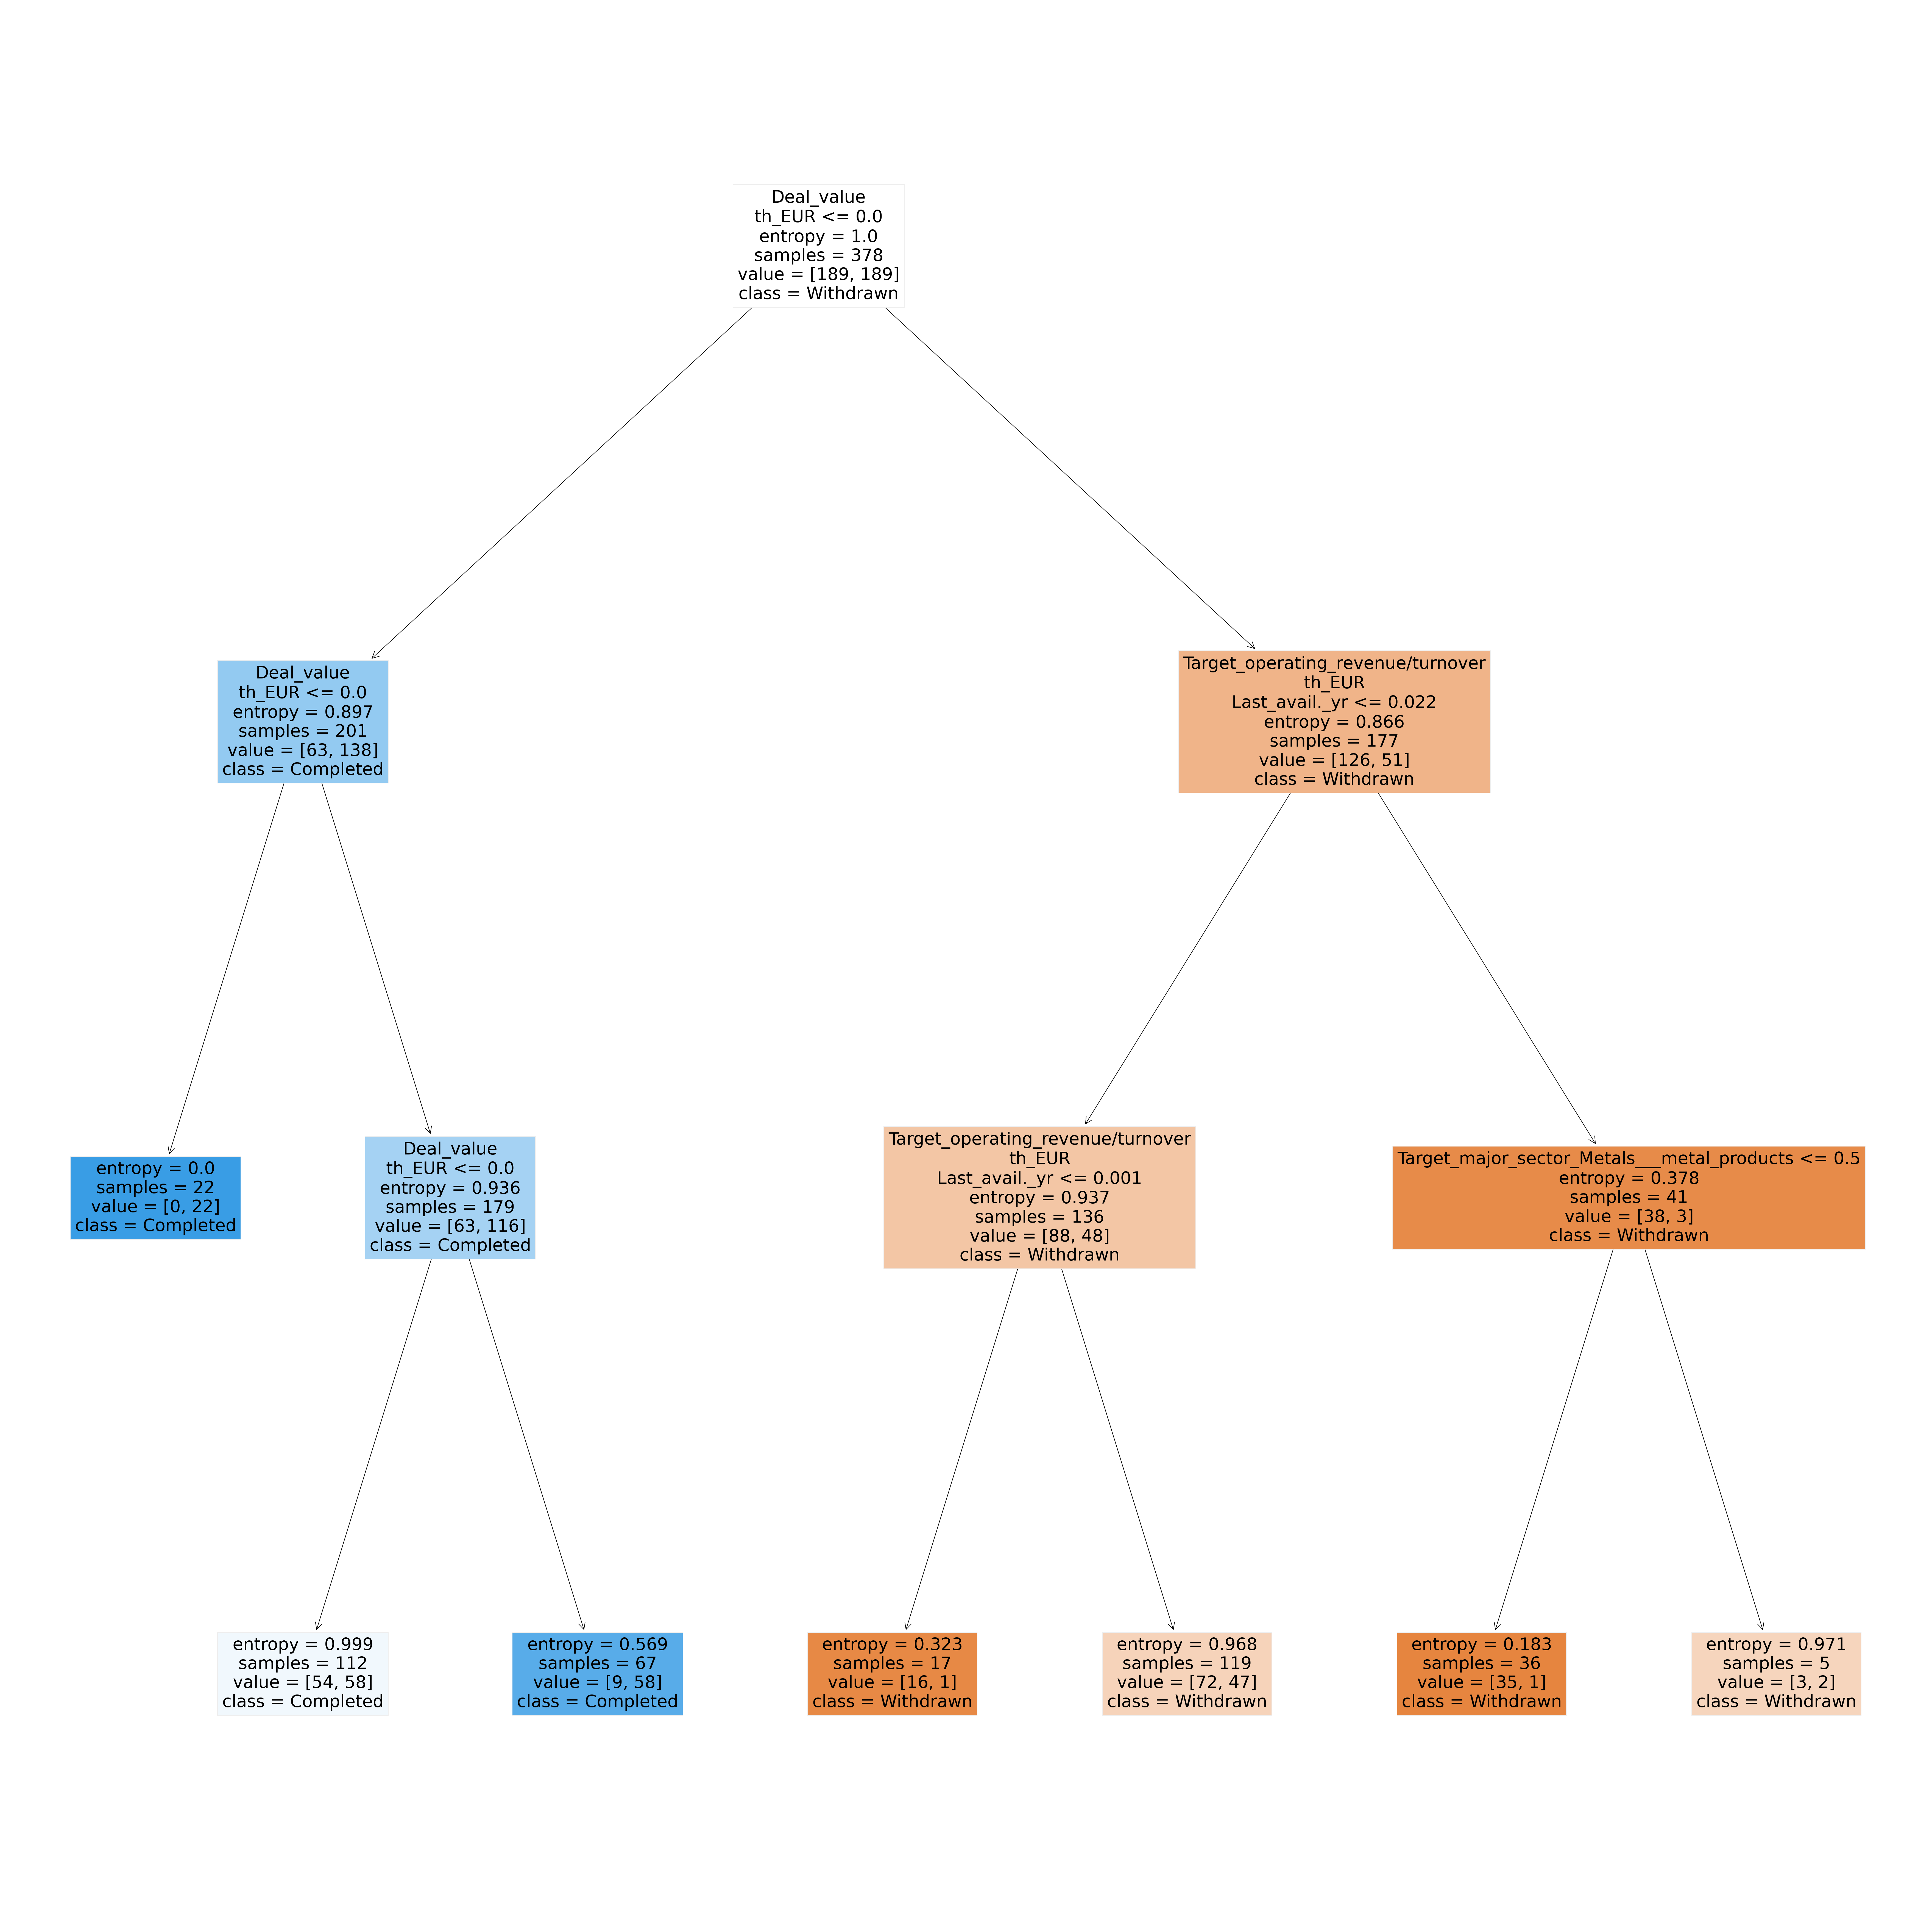

In [31]:
# Decision Tree Tuning

dt, auc3, auc3 = do_classify(DecisionTreeClassifier(), param3, X_train,y_train,X_test,y_test, score_func='roc_auc', 
                                 n_folds=5, n_jobs=2,model_name='model',label=1,prob_dec=1)

def plot_tree(clf, features):
    
    # Setting dpi = 300 to make image clearer than default
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,30), dpi=300)

    tree.plot_tree(clf,
           feature_names=features,
            # string class names must equate to their numerical representation in ascending order 
           class_names=["Withdrawn", "Completed"],
           filled=True,
           fontsize=15);
    # fig.savefig('tree.png')
    
plot_tree(dt, X_train.columns.tolist())

Text(0.5, 0, 'Relative Importance based on Information Gain (entropy)')

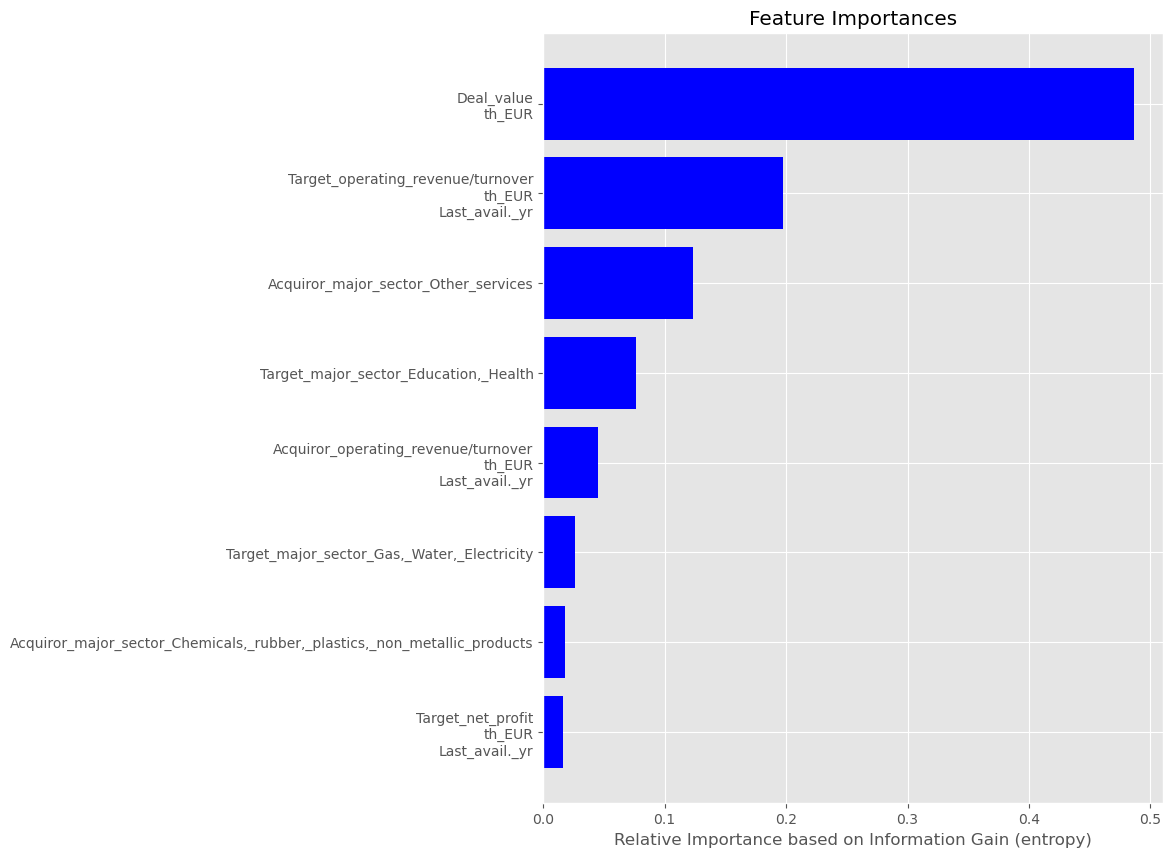

In [32]:
# plot features importances determined by RandomForest
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

f=plt.figure()
f.set_figwidth(8)
f.set_figheight(10)
plt.title('Feature Importances')
plt.barh(range(8), importances[indices][-8:], color='b', align='center')
plt.yticks(range(8), features[indices][-8:])
plt.xlabel('Relative Importance based on Information Gain (entropy)')